In [4]:
!pip install einops
!which jupyter

/home/annie/miniconda3/envs/text2fx/bin/jupyter


In [1]:
import os
from pathlib import Path
import requests
from tqdm import tqdm
from typing import Union, List

import math
import torch
import numpy as np
import audiotools
import dasp_pytorch
import auraloss
# import laion_clap
from audiotools import AudioSignal

from transformers import BertForMaskedLM

from scipy import signal
import matplotlib.pyplot as plt

import helper

dir(helper)

['AudioSignal',
 'BertForMaskedLM',
 'List',
 'Path',
 'Union',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'audiotools',
 'auraloss',
 'compare_loss_anyfiles',
 'convert_to_freq_gain_tuples',
 'convert_to_tensors',
 'dasp_apply_multiple_filters',
 'dasp_apply_multiple_filters_file',
 'dasp_pytorch',
 'find_paths_with_keyword',
 'find_settings_for_word',
 'get_settings_for_words',
 'json',
 'load_and_find_path_with_keyword',
 'load_examples',
 'math',
 'np',
 'os',
 'plot_eq_curve',
 'plt',
 'requests',
 'signal',
 'torch',
 'tqdm']

In [2]:
NOTEBOOKS_DIR = Path(os.path.abspath(''))
PROJECT_DIR = NOTEBOOKS_DIR.parent
ASSETS_DIR = PROJECT_DIR / "assets"
PRETRAINED_DIR = PROJECT_DIR / "pretrained"
DATA_DIR = PROJECT_DIR / "data"
RUNS_DIR = PROJECT_DIR / "runs"
EXPERIMENTS_DIR = PROJECT_DIR / "experiments"


EXP_AUDEALIZE_DIR = EXPERIMENTS_DIR / "audealize_comp"
EXPORT_EXAMPLES_DIR = Path(EXP_AUDEALIZE_DIR / "audealize_version")

print(ASSETS_DIR)

/home/annie/research/text2fx/assets


### Setting Up Audealize Ground Truth Files

##### Loading in Audealize API / word <> EQ settings

In [3]:
# Load JSON data Audealize API word <> EQ gain values
file_path = '/home/annie/research/text2fx/notebooks/audealize_data/eqdescriptors.json'
top10_eq = ["warm", "cold", "soft", "loud", "happy", "bright", "soothing", "harsh", "heavy", "cool"]
settings_dict = helper.get_settings_for_words(file_path, top10_eq)
# print(settings_dict['cool'])

# Zipping (frequency bands, gain vals) in dictionary
freq_bands = [20, 50, 83, 120, 161, 208, 259, 318, 383, 455, 537, 628, 729, 843, 971, 
              1114, 1273, 1452, 1652, 1875, 2126, 2406, 2719, 3070, 3462, 3901, 
              4392, 4941, 5556, 6244, 7014, 7875, 8839, 9917, 11124, 12474, 13984, 
              15675, 17566, 19682]

converted_settings_dict = helper.convert_to_freq_gain_tuples(settings_dict, freq_bands)
# print(converted_settings_dict['cold'])

# Converting all parameters into tensors
tensor_settings = helper.convert_to_tensors(converted_settings_dict)
# print(tensor_settings['cold'])

In [4]:
# Loading audealize ground truth files
all_audealize_samples = helper.load_and_find_path_with_keyword(ASSETS_DIR, ["audealize"], returnSingle=False)
# all_audealize_samples = helper.load_and_find_path_with_keyword(ASSETS_DIR, ["audealize", "piano"], returnSingle=False)

print(all_audealize_samples)

[PosixPath('/home/annie/research/text2fx/assets/audealize_examples/drums.wav'), PosixPath('/home/annie/research/text2fx/assets/audealize_examples/guitar.wav'), PosixPath('/home/annie/research/text2fx/assets/audealize_examples/piano.wav')]


##### Generating Audealize Gnd Truth Examples

In [ ]:
# Original Input
audio_type = "drums"

#loading clean file
input_raw= helper.load_and_find_path_with_keyword(ASSETS_DIR, [audio_type], returnSingle=True) #searches for file
input_sig = AudioSignal(input_raw).to_mono()

# generating output files
for word, freq_gains in tensor_settings.items():
    filtered_sig = helper.dasp_apply_multiple_filters_file(input_raw, freq_gains)
    filter_out = AudioSignal(filtered_sig,input_sig.sample_rate)
    print(f'saving {word}')

    EXPORT_EX_DIR = Path(EXPORT_EXAMPLES_DIR / f"{audio_type}")
    EXPORT_EX_DIR.mkdir(exist_ok=True)

    filter_out.write(Path(EXPORT_EX_DIR, f"{word}.wav"))

### Comparing Audealize Files with Other Embeddings

### Audealize vs MS CLAP: 
- FX: Just EQ
- Words: Top 10 Frequent EQ words (warm 64, cold 34, soft 29, loud 26, happy 22, bright 19, soothing 17, harsh 16, heavy 15, cool 14)



##### Audio Type: Guitar Riff

In [ ]:
# Loading Ground Truth Paths
audealize_out_ALL = helper.load_and_find_path_with_keyword(EXPORT_EXAMPLES_DIR, ["guitar"], returnSingle=False)
print(len(audealize_out_ALL)) #checking length, should be number of words aka 10
# for path in audealize_out_ALL:
#     print(path)

# Loading all MS CLAP output files
MS_CLAP_OUTPUTS = EXP_AUDEALIZE_DIR / "ms_clap" 
msclap_out_ALL = helper.load_and_find_path_with_keyword(MS_CLAP_OUTPUTS, ["guitar", "final"])
print(len(msclap_out_ALL))  #checking length, should be number of words aka 10
# for path in msclap_out_ALL:
#     print(path)

In [ ]:
target_word = 'warm'

audealize_out_word = helper.load_and_find_path_with_keyword(EXPORT_EXAMPLES_DIR, ["guitar", f"{target_word}"], returnSingle=True)
msclap_out_word = helper.load_and_find_path_with_keyword(MS_CLAP_OUTPUTS, ["guitar", "final", f"{target_word}"], returnSingle=True)

print(audealize_out_word)
print(msclap_out_word)

In [ ]:
helper.compare_loss_anyfiles(audealize_out_word, msclap_out_word)

In [ ]:
def calculate_losses(audio_type, verbose=True):
    losses = []
    for word in top10_eq:
        target_word = word
        audealize_out_word = helper.load_and_find_path_with_keyword(EXPORT_EXAMPLES_DIR, [f"{audio_type}", f"{target_word}"], returnSingle=True)
        msclap_out_word = helper.load_and_find_path_with_keyword(MS_CLAP_OUTPUTS, [f"{audio_type}", "final", f"{target_word}"], returnSingle=True)
        if verbose:
            print(f'AUDEALIZE_OUT PATH: {audealize_out_word}')
            print(f'MS_CLAP_OUT PATH: {msclap_out_word}')

        loss = helper.compare_loss_anyfiles(audealize_out_word, msclap_out_word)
        losses.append((word, loss))
        print(audio_type, word, loss)
    return losses

In [ ]:
losses = calculate_losses("guitar", verbose=False)

In [ ]:
losses = calculate_losses("drums", verbose=False)

In [ ]:
### testing for 2

In [11]:

def TESTdasp_apply_multiple_filters_file(file_name, filters, Q=4.31):
    """
    file(input signal) = MONO ONLY, torch tensor of samples, if audiosignal, set to AudioSignal.samples 
                        shape is (bs, n_channels, signals)
                        ex torch.Size([1, 1, 451714])
    filters = list of (frequency, gain_db) pairs
    fs = should be fs of x
    returns filtered signal as (bs, n_channels, signals)
    """
    audio = AudioSignal(file_name)
    x = audio.samples
    fs = audio.sample_rate
    filtered_signal = x.clone()  # Make a copy of the original signal

    # combine batch and channel dims
    # filtered_signal = rearrange(filtered_signal, "b c t -> (b c) 1 t") 
    nb,nc,nt = filtered_signal.shape
    filtered_signal= filtered_signal.view(nb*nc,1,nt)
    print(nb)
    f_resp = []
    Q = torch.tensor(Q)
    for f0, gain_db in filters:
        b, a = dasp_pytorch.signal.biquad(gain_db*5, f0, Q, fs, 'peaking')         # Design peak filter
        filtered_signal = dasp_pytorch.signal.lfilter_via_fsm(filtered_signal, b, a)

    filtered_signal= filtered_signal.view(nb,nc,nt)
    
    return filtered_signal, fs


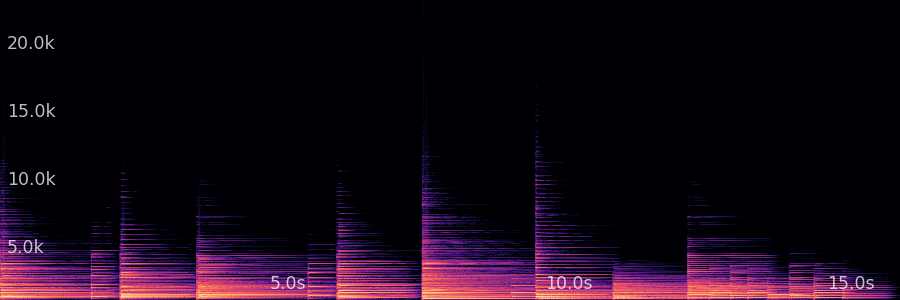
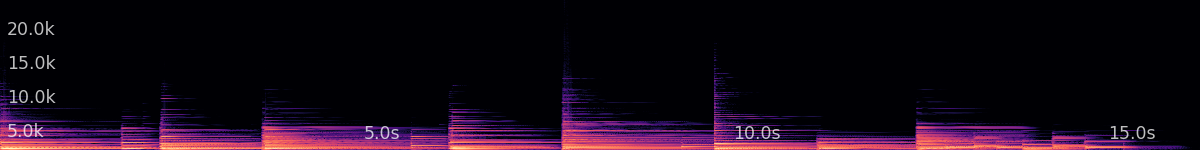

1



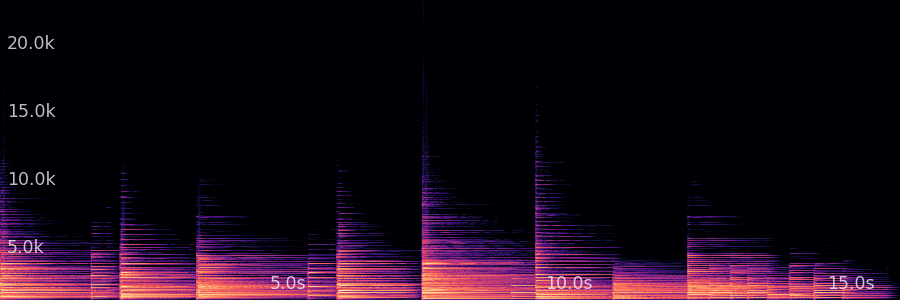
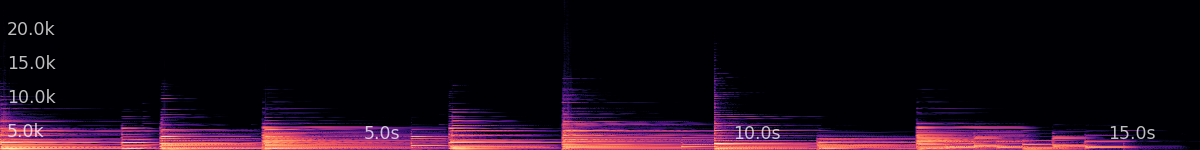

In [12]:
AudioSignal(all_audealize_samples[2]).widget()
outsig, fs = TESTdasp_apply_multiple_filters_file(all_audealize_samples[2], tensor_settings['cold'])
AudioSignal(outsig, fs).widget()